Stochastic SIR Model with testing (no removal of tested individuals from population).

Reaction - Propensity
- S+I -> 2I - beta(s,i)
- I -> R - gamma(s,i)
- S -> S + St - lambdas(s,i,r) (Implies that a susceptible and a tested susceptible behave in the same way)
- I -> I + It - lambdai(s,i,r) (" ")
- R -> R + Rt - lambdar(s,i,r) (" ")

For unbiased testing, we take

- lambdas = lambda S/(S+I+R)
- lambdai = lambda I/(S+I+R)
- lambdar = lambda R/(S+I+R)

For biased testing we take

- lambdas = lambda a1S/(a1S+a2I+a3R)
- lambdai = lambda a2I/(a1S+a2I+a3R)
- lambdar = lambda a3R/(a1S+a2I+a3R)

We may wish to vary lambda and a1,a2,a3 some "test availability" parameter.

In [1]:
import numpy as np
from numpy.random import exponential as exp
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.integrate import ode

In [192]:
#we will generate test simulations with Gillespie's algorithm
def stochastic_sir(x0,end_time,beta_fun,gamma_fun,lambda_fun,bias_fun,LambdaMax):
    s,i,r = x0
    tested_neg = 0
    tested_pos = 0
    total_pos = i
    t = 0
    t_list = [t]
    sir_list = [[s,i,r]]
    tested_neg_list = [0]
    tested_pos_list = [0]
    total_pos_list = [total_pos]
    
    while (t < end_time) or ((len(t_list))<100):
        beta = beta_fun(s,i,r,t)
        gamma = gamma_fun(s,i,r,t)
        lamb0 = beta+gamma+LambdaMax
      
        
        if lamb0:
            dt = exp(1/lamb0)
            t = t+dt 

            u  = rand()
        
            if u < beta/lamb0: #next event is infection
                s = s-1
                i = i+1 #change s,i
                sir_list += [[s,i,r]]
                total_pos += 1 #record a new (real) positive
                total_pos_list += [total_pos]
                tested_pos_list += [tested_pos]
                tested_neg_list += [tested_neg]
                t_list += [t] #update time.
            elif u < (beta + gamma)/lamb0: #next event is recovery
                i = i-1
                r = r+1 #change i,r
                sir_list += [[s,i,r]]
                total_pos_list += [total_pos] 
                tested_pos_list += [tested_pos]
                tested_neg_list += [tested_neg]
                t_list += [t] #update time.
            else: #next event is a test or nothing.
                lamb = lambda_fun(s,i,r,t,LambdaMax)
                bias = bias_fun(s,i,r,t)
                bias_N = s*bias[0] + i*bias[1] + r*bias[2]
                lambdas = lamb*bias[0]*s/bias_N
                lambdai = lamb*bias[1]*i/bias_N
                lambdar = lamb*bias[2]*r/bias_N
                total_pos_list += [total_pos] 
                sir_list += [[s,i,r]]
                if u < (beta+gamma+lambdas)/lamb0: #tested a "s"
                    tested_neg += 1
                    tested_neg_list += [tested_neg]
                    tested_pos_list += [tested_pos]
                    t_list += [t] #update time.
                elif u < (beta+gamma+lambdas+lambdai)/lamb0: #tested a "i"
                    tested_pos += 1
                    tested_pos_list += [tested_pos]
                    tested_neg_list += [tested_neg]
                    t_list += [t] #update time.
                elif u < (beta+gamma+lambdas+lambdai+lambdar)/lamb0: #tested a "r"
                    tested_neg += 1
                    tested_neg_list += [tested_neg]
                    tested_pos_list += [tested_pos]
                    t_list += [t] #update time.
                
                
        else:
            break
        
    return (np.array(t_list), np.array(sir_list), np.array(total_pos_list)), (np.array(t_list),np.array(tested_neg_list),np.array(tested_pos_list))



In [199]:
N = 100
LambdaMax = 10

init_inf = 0.01
izero = int(init_inf*N)
szero = N-izero

R0 = 3

In [235]:
def Beta(s,i,r,t):
    return (R0)*s*i/(s+i+r)
def Gamma(s,i,r,t):
    return i
def Lamb(s,i,r,t,LM):
    return LM*t/(1+t)
def Bias(s,i,r,t):
    return [1,1,1]

In [201]:
infection,testing = stochastic_sir([szero,izero,0],15,Beta,Gamma,Lamb,Bias,LambdaMax)

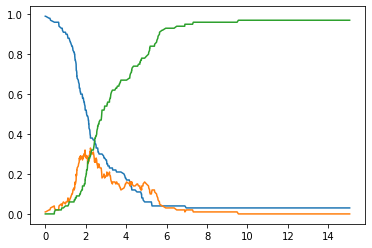

In [202]:
plt.plot(infection[0],infection[1]/N)

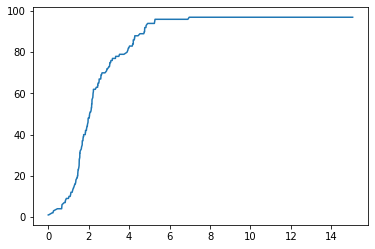

In [203]:
plt.plot(infection[0],infection[2])

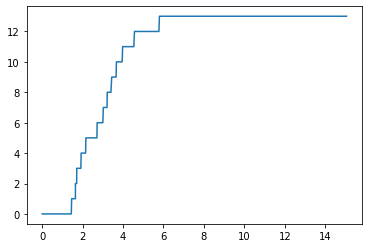

In [204]:
plt.plot(testing[0],testing[2])

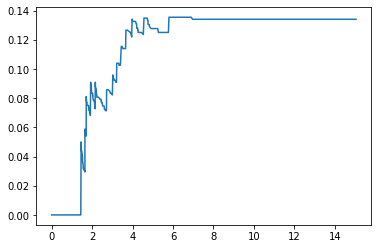

In [205]:
plt.plot(testing[0],testing[2]/infection[2])

In [206]:
np.max(testing[2]/infection[2])

0.13541666666666666

Below, we have the non-dimensionalized deterministic SIR model.

In [211]:
def SIR_model_rescaled(t,X,params):
    R0 = params
    s,i,r= X
    dsdt = -R0*s*i
    didt = -dsdt - i
    drdt = i
    return [dsdt,didt,drdt]

In [213]:
s0 = (1-init_inf)
i0 = init_inf
r0 = 0

t0 = 0 
end_time = 10
tst = 0.01

sir_sol = ode(SIR_model_rescaled)
sir_sol.set_f_params(np.array([R0]))
sir_sol.set_initial_value([s0,i0,r0],0)

time_array = np.array([t0])
sol_list = [[s0,i0,r0,i0]]
for tpt in np.arange(t0,end_time,tst):
    s,i,r = sir_sol.integrate(sir_sol.t + tst)
    sol_list = sol_list + [[s,i,r,T]]
    time_array = np.append(time_array,sir_sol.t)
sol_array = np.array(sol_list)
sim_length = len(sol_array)

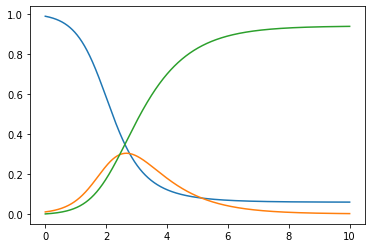

In [214]:
plt.plot(time_array,sol_array.T[0],time_array,sol_array.T[1],time_array,sol_array.T[2])

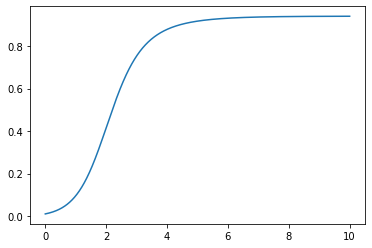

In [217]:
plt.plot(time_array,s0-sol_array.T[0] + i0)

We can model stochastic sampling of the deterministic model. Because we have propensities that sum to lambda, we this is (relatively) easy if lambda is constant. If lambda is not constant, we can still compute without much difficulty as long as we have a relatively tight upper bound on lambda. We'll call this lambdaMax.

Below, we compute the trajectory as well as counting sampling.

In [236]:
def sample_traj(x0,t0,end_time,dynamics,dynamics_params,lambdafun,biasfun,LambdaMax):
    
    #dynamics should model susceptible, infected, recovered. (for now)

    s0,i0,r0 = x0

    odemod = ode(dynamics)
    odemod.set_f_params(dynamics_params)
    odemod.set_initial_value([s0,i0,r0],0)
    
    tot_cases = [i0]

    time_array = np.array([t0])
    st,it,rt = [0,0,0]
    test_list = [[st,it,rt]]
    t = 0
    
    while odemod.successful and odemod.t < end_time:
        dt = exp(1/LambdaMax)
        s,i,r = odemod.integrate(odemod.t + dt)
        lamb = lambdafun(s,i,r,odemod.t,LambdaMax)
        bias = biasfun(s,i,r,odemod.t)
        bias_N = s*bias[0] + i*bias[1] + r*bias[2]
        lambdas = lamb*bias[0]*s/bias_N
        lambdai = lamb*bias[1]*i/bias_N
        lambdar = lamb*bias[2]*r/bias_N
        u = LambdaMax*rand()
        if u < lambdas: #tested a "s"
            st += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]
        elif u < (lambdas + lambdai): #tested a "i"
            it += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]
        elif u < (lambdas + lambdai + lambdar): #tested a "r"
            rt += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]

    return time_array,np.array(test_list),np.array(tot_cases)
            


        

In [237]:
t,tests,cases = sample_traj([s0,i0,r0],0,10,SIR_model_rescaled,np.array([R0]),Lamb,Bias,LambdaMax)

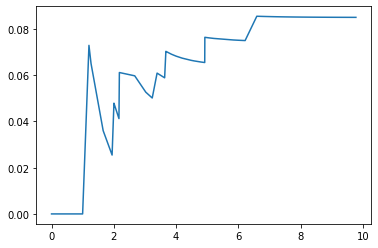

In [238]:
plt.plot(t,tests.T[1]/(N*cases))

In [ ]:
plt.plot(t,tests.T[1]/cases)